In [1]:
%load_ext autotime

In [2]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import numpy as np
from collections import Counter

from covid19_abm.dir_manager import get_data_dir

time: 1.97 s


In [3]:
age_map = {
    'less than 1 year': 0,
    'less than 1 year ': 0,
    '1 year': 1,
    '1 year ': 1,
    '2 years': 2,
    '2 years ': 2,
    '98': 98,
    '98 ': 98,
    'not reported/missing': None,
    'not reported/missing ': None,
}

econ_stat_map = {
    'Not working, inactive, not': 'Not working, inactive, not in universe',
}

time: 582 µs


In [4]:
#full_individual_df = pd.read_stata(
 #   get_data_dir('raw', 'census', 'census_dummy_0.001_pct'))
    
#for unknown reasons this code doesn't work

time: 348 µs


In [5]:
full_individual_df = pd.read_stata('/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/data/raw/census/census_dummy_0.001_pct.dta')

time: 152 ms


In [6]:
full_individual_df['age'] = full_individual_df['age'].map(lambda x: age_map.get(x, x))
full_individual_df['economic_status'] = full_individual_df['economic_status'].str.strip().map(lambda x: econ_stat_map.get(x, x))

time: 7.78 ms


In [7]:
full_individual_df.head()

serial  persons district_id  new_district_id age     sex teachers  \
0  3645901        6          21                1  32  female        0   
1  2837395        3          21                1   3  female        0   
2  3643108        4          21                1  27  female        0   
3   127433        6          21                1   9    male        0   
4   142476        8          21                1  19    male        0   

      nfams                isco88a  famunit  ... new_dist_pop_share   geo1_zw  \
0  1 family  niu (not in universe)        1  ...                1.0  bulawayo   
1  1 family  niu (not in universe)        1  ...                1.0  bulawayo   
2  1 family  niu (not in universe)        1  ...                1.0  bulawayo   
3  1 family  niu (not in universe)        1  ...                1.0  bulawayo   
4  1 family  niu (not in universe)        1  ...                1.0  bulawayo   

  geo1_zw2012 geo1_string         geo2_zw     geo2_zw2012 dhs_ipumsi_zw  \
0    bulawayo           0  bulawayo urban  bulawayo urban      bulawayo   
1    bulawayo           0  bulawayo urban  bulawayo urban      bulawayo   
2    bulawayo           0  bulawayo urban  bulawayo urban      bulawayo   
3    bulawayo           0  bulawayo urban  bulawayo urban      bulawayo   
4    bulawayo           0  bulawayo urban  bulawayo urban      bulawayo   

  province_id_shpfile province_name_shpfile district_name_shpfile  
0                   1              Bulawayo              Bulawayo  
1                   1              Bulawayo              Bulawayo  
2                   1              Bulawayo              Bulawayo  
3                   1              Bulawayo              Bulawayo  
4                   1              Bulawayo              Bulawayo  

[5 rows x 59 columns]

time: 72.6 ms


In [8]:
l = '''Not working, inactive, not in universe
In School
Homemakers/Housework
Office workers
Service Workers
Agriculture Workers
Disabled and not working'''
l = l.split('\n')
full_individual_df['economic_status'].value_counts()[l]

# industry workers and in the army have been removed from here because they are not in the smaller sample

Not working, inactive, not in universe    41
In School                                 36
Homemakers/Housework                      17
Office workers                             2
Service Workers                           21
Agriculture Workers                       23
Disabled and not working                   1
Name: economic_status, dtype: int64

time: 8.64 ms


# Fill unknown age

In [9]:
individual_df = full_individual_df

time: 395 µs


In [10]:
# missing_val = 'not reported/missing'
age_cols = ['geo1_zw2012', 'urban', 'persons', 'sex', 'marst', 'citizen', 'race', 'disabled', 'economic_status']
X = pd.get_dummies(individual_df[age_cols], drop_first=True)

X_train = X[individual_df['age'].notnull()]

time: 56.8 ms


In [11]:
gb = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=1029)
# rf = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=1029, n_jobs=50)

frac = 0.05
X_tr = X_train.sample(frac=frac, random_state=1029)
gb.fit(X_tr, individual_df.loc[X_tr.index, 'age'])

missing_age = X[individual_df['age'].isnull()]

time: 69 ms


<AxesSubplot:>

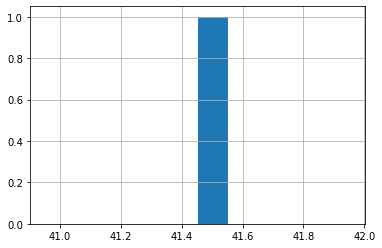

time: 813 ms


In [12]:
pd.Series(gb.predict(missing_age)).hist()

In [13]:
X_tr.shape

(7, 25)

time: 3.93 ms


In [14]:
individual_df.loc[missing_age.index, 'age'] = gb.predict(missing_age).astype(int)
individual_df.loc[missing_age.index].head()

serial  persons district_id  new_district_id age     sex teachers  \
71  988027        8        3007               22  41  female        0   

       nfams                                       isco88a  famunit  ...  \
71  1 family  subsistence agricultural and fishery workers        1  ...   

   new_dist_pop_share           geo1_zw       geo1_zw2012 geo1_string geo2_zw  \
71           0.108041  mashonaland east  mashonaland east           3  mutoko   

   geo2_zw2012     dhs_ipumsi_zw province_id_shpfile province_name_shpfile  \
71      mutoko  mashonaland east                   5      Mashonaland East   

   district_name_shpfile  
71                Mutoko  

[1 rows x 59 columns]

time: 65.7 ms


In [15]:
individual_df.economic_status.astype(str).value_counts()

Not working, inactive, not in universe    41
In School                                 36
Agriculture Workers                       23
Service Workers                           21
Homemakers/Housework                      17
Office workers                             2
Disabled and not working                   1
Name: economic_status, dtype: int64

time: 8.13 ms


## Create `district_id`, `household_id` and `economic_activity_location_id`

In [16]:
relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id',
    'economic_status', 'economic_activity_location_id',
    # 'household', 'district'
]

time: 808 µs


In [17]:
old_new_districts = pd.read_csv('/Users/sophieayling/Documents/GitHub/covid19-agent-based-model/data/raw/district_relation.csv', index_col=0)
old_new_districts.index = old_new_districts['ADMIN_NAME'].str.lower()

time: 10.4 ms


In [18]:
individual_df['serial_expanded'] = individual_df['serial']

time: 6 ms


In [19]:
individual_df['household_id'] = individual_df['serial_expanded'].map(lambda x: f'h_{x}')
individual_df['old_district_id'] = individual_df['geo2_zw2012'].map(lambda x: f'd_{old_new_districts["DIST2012"][x]}')                                          
individual_df['new_district_id'] = individual_df['geo2_zw2012'].map(lambda x: f'd_{old_new_districts["NEW_DIST_ID_2"][x]}')

time: 10 ms


In [20]:
expanded_individual_df = individual_df.copy()

time: 4.4 ms


In [21]:
expanded_individual_df.head()

serial  persons district_id new_district_id age     sex teachers  \
0  3645901        6          21             d_1  32  female        0   
1  2837395        3          21             d_1   3  female        0   
2  3643108        4          21             d_1  27  female        0   
3   127433        6          21             d_1   9    male        0   
4   142476        8          21             d_1  19    male        0   

      nfams                isco88a  famunit  ... geo1_string         geo2_zw  \
0  1 family  niu (not in universe)        1  ...           0  bulawayo urban   
1  1 family  niu (not in universe)        1  ...           0  bulawayo urban   
2  1 family  niu (not in universe)        1  ...           0  bulawayo urban   
3  1 family  niu (not in universe)        1  ...           0  bulawayo urban   
4  1 family  niu (not in universe)        1  ...           0  bulawayo urban   

      geo2_zw2012 dhs_ipumsi_zw province_id_shpfile province_name_shpfile  \
0  bulawayo urban      bulawayo                   1              Bulawayo   
1  bulawayo urban      bulawayo                   1              Bulawayo   
2  bulawayo urban      bulawayo                   1              Bulawayo   
3  bulawayo urban      bulawayo                   1              Bulawayo   
4  bulawayo urban      bulawayo                   1              Bulawayo   

  district_name_shpfile serial_expanded household_id old_district_id  
0              Bulawayo         3645901    h_3645901            d_21  
1              Bulawayo         2837395    h_2837395            d_21  
2              Bulawayo         3643108    h_3643108            d_21  
3              Bulawayo          127433     h_127433            d_21  
4              Bulawayo          142476     h_142476            d_21  

[5 rows x 62 columns]

time: 68.3 ms


In [22]:
expanded_individual_df['school_goers'] = 1 * (expanded_individual_df['school_goers'] != 0)

time: 4.99 ms


In [23]:
expanded_individual_df.columns

Index(['serial', 'persons', 'district_id', 'new_district_id', 'age', 'sex',
       'teachers', 'nfams', 'isco88a', 'famunit', 'urban', 'economic_status',
       'gq', 'marst', 'citizen', 'race', 'disabled', 'disblnd', 'disdeaf',
       'dismntl', 'famsize', 'age2', 'edattain', 'edattaind', 'yrschool',
       'educzw', 'empstat', 'empstatd', 'labforce', 'occisco', 'occ',
       'manufacturing_workers', 'mining_workers', 'mining_districts', 'pid',
       'weight', 'ward', 'school_goers', 'school_goers_detailed', 'pernum',
       'geolev1', 'Province', 'Province_str', 'ProvincePop2012',
       'ProvincePop2019', 'geolev2', 'new_district_id_st', 'NewDistPop2012',
       'NewDistPop2019', 'new_dist_pop_share', 'geo1_zw', 'geo1_zw2012',
       'geo1_string', 'geo2_zw', 'geo2_zw2012', 'dhs_ipumsi_zw',
       'province_id_shpfile', 'province_name_shpfile', 'district_name_shpfile',
       'serial_expanded', 'household_id', 'old_district_id'],
      dtype='object')

time: 4.11 ms


In [24]:
expanded_individual_df.groupby('serial')['sex'].count().mean()

1.0

time: 6.82 ms


In [25]:
expanded_individual_df.shape[0] / expanded_individual_df['serial'].nunique()

1.0

time: 4.29 ms


In [26]:
(expanded_individual_df['school_goers'] == 1).sum()

36

time: 4.06 ms


In [27]:
(expanded_individual_df['school_goers'] == 1).sum()

36

time: 5.2 ms


# Mining

In [42]:
# relevant_cols = [
#     'person_id', 'age', 'sex',
#     'household_id', 'district_id',
#     'economic_status', 'economic_activity_location_id',
#     'school_id_district', 
#     'manufacturing_workers',
#     'mining_district_id'
#     # 'household', 'district'
# ]

relevant_cols = [
    'person_id', 'age', 'sex',
    'household_id', 'district_id', 'old_district_id', 'old_district_id1',
    'economic_status', 'economic_activity_location_id',
    # 'school_id_district', 
    'school_goers',
    'manufacturing_workers',
    # 'mining_district_id'
    # 'household', 'district'
]

time: 629 µs


In [43]:
mining_df = expanded_individual_df.copy()

p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_district_id']

try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'district_id': 'old_district_id1'}, inplace=True) # added 30th Nov (Sophie, Anne, Sarah)

mining_df.rename(columns={'new_district_id': 'district_id'}, inplace=True)

mining_df[relevant_cols].to_pickle(
    get_data_dir('preprocessed', 'census', 'zimbabwe_ipums_mining_manufacturing_school_new_dist_100pct.pickle'))

***FLAG***/Users/sophieayling/Documents/GitHub/covid19-agent-based-model
time: 22.6 ms


In [44]:
mining_df[relevant_cols].head()

person_id  age     sex household_id district_id old_district_id  \
0          0   32  female    h_3645901         d_1            d_21   
1          1    3  female    h_2837395         d_1            d_21   
2          2   27  female    h_3643108         d_1            d_21   
3          3    9    male     h_127433         d_1            d_21   
4          4   19    male     h_142476         d_1            d_21   

  old_district_id1                         economic_status  \
0               21                    Homemakers/Housework   
1               21  Not working, inactive, not in universe   
2               21  Not working, inactive, not in universe   
3               21  Not working, inactive, not in universe   
4               21                               In School   

  economic_activity_location_id  school_goers  manufacturing_workers  
0                           d_1             0                    0.0  
1                           d_1             0                    0.0  
2                           d_1             0                    0.0  
3                           d_1             0                    0.0  
4                           d_1             1                    0.0

time: 17.8 ms


# Contingent on available data

In [31]:
# mining_df['serial_expanded'] = mining_df['serial'].map(lambda x: f'{x}_01')
# mining_df['household_id'] = mining_df['serial_expanded'].map(lambda x: f'h_{x}')
mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'] = mining_df.loc[mining_df['mining_district_id'] != '', 'mining_district_id'].map(lambda x: f'mining_{x}')
mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'] = mining_df.loc[mining_df['school_id_district'] != '', 'school_id_district'].map(lambda x: f'school_{x}')

KeyError: 'mining_district_id'

time: 414 ms


In [ ]:
mining_df.head()

In [ ]:
p = mining_df['economic_status']

mining_df.loc[p == 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p == 'Disabled and not working', 'household_id']
mining_df.loc[p != 'Disabled and not working', 'economic_activity_location_id'] = mining_df.loc[p != 'Disabled and not working', 'new_district_id']

In [ ]:
try:
    mining_df.drop('person_id', axis=1, inplace=True)
except KeyError:
    pass

mining_df['person_id'] = mining_df.index
mining_df['age'] = mining_df['age'].astype(int)
mining_df['economic_status'] = mining_df['economic_status'].str.strip()
mining_df.rename(columns={'new_district_id': 'district_id'}, inplace=True)

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_5pct.pickle')

In [ ]:
mining_df[relevant_cols][
    mining_df.serial_expanded.str.endswith('_01') | mining_df.serial_expanded.str.endswith('_02')
].to_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df.shape

In [ ]:
import pandas as pd

In [ ]:
mining_df = pd.read_pickle('../../data/zimbabwe_ipums_mining_manufacturing_school_new_dist_10pct.pickle')

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id']

# Expand to 10%

In [ ]:
mining_df

# Scratch

In [ ]:
mining_df[~mining_df['household_id'].str.startswith('h_')]['person_id'].values

In [ ]:
mining_df[mining_df.manufacturing_workers.notnull()].person_id

In [ ]:
mining_df[mining_df['manufacturing_workers'].notnull()]['person_id'].values

In [ ]:
mining_df[mining_df['school_id_district'] != '']['person_id'].values

In [ ]:
mining_df['school_id_district'].shape